图像MNIST数据集
使用Scikit-learn加载简化版MNIST数据集

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

# 加载数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
data = mnist.data
target = mnist.target.astype(int)  # 将标签转换为整数

随机展示多张图片

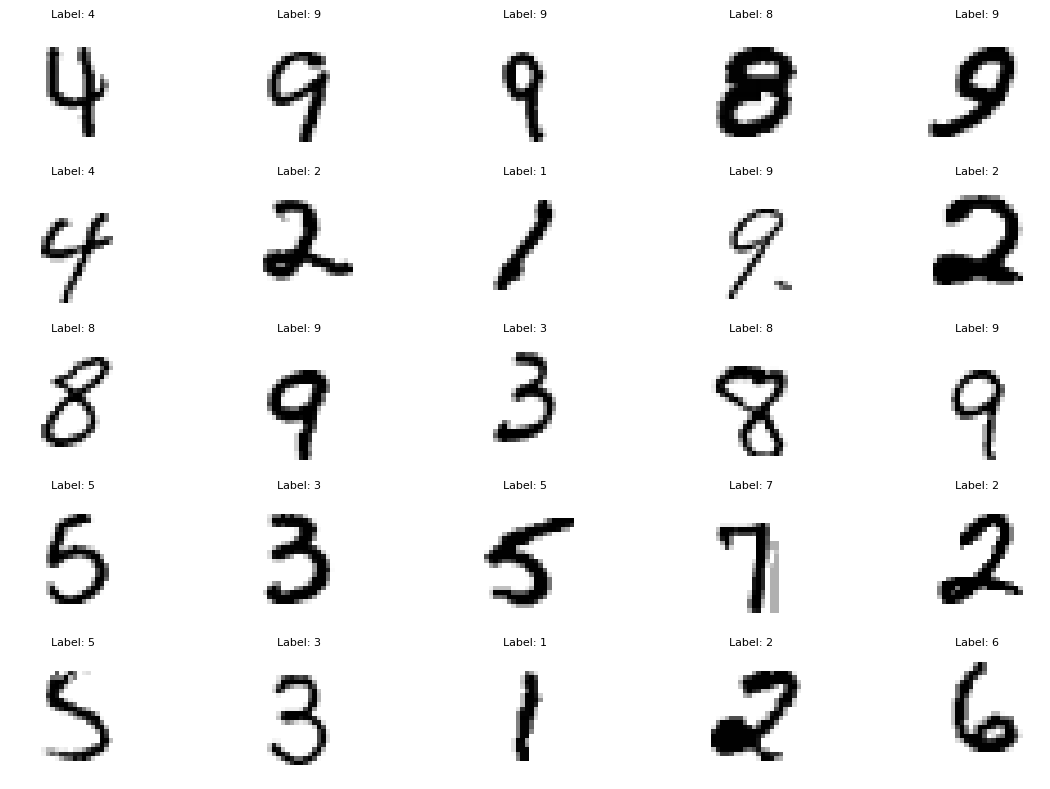

In [6]:
def show_grid(samples=25, rows=5):
    cols = samples // rows
    plt.figure(figsize=(12, 8))
    indexes = np.random.choice(len(data), samples, replace=False)
    
    for i, idx in enumerate(indexes):
        plt.subplot(rows, cols, i+1)
        plt.imshow(data[idx].reshape(28, 28), cmap='gray_r')
        plt.title(f"Label: {target[idx]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_grid()  # 显示25张随机图片

MNIT验证感知机

Training class 0 vs rest...
Training class 1 vs rest...
Training class 2 vs rest...
Training class 3 vs rest...
Training class 4 vs rest...
Training class 5 vs rest...
Training class 6 vs rest...
Training class 7 vs rest...
Training class 8 vs rest...
Training class 9 vs rest...

测试集准确率: 87.90%


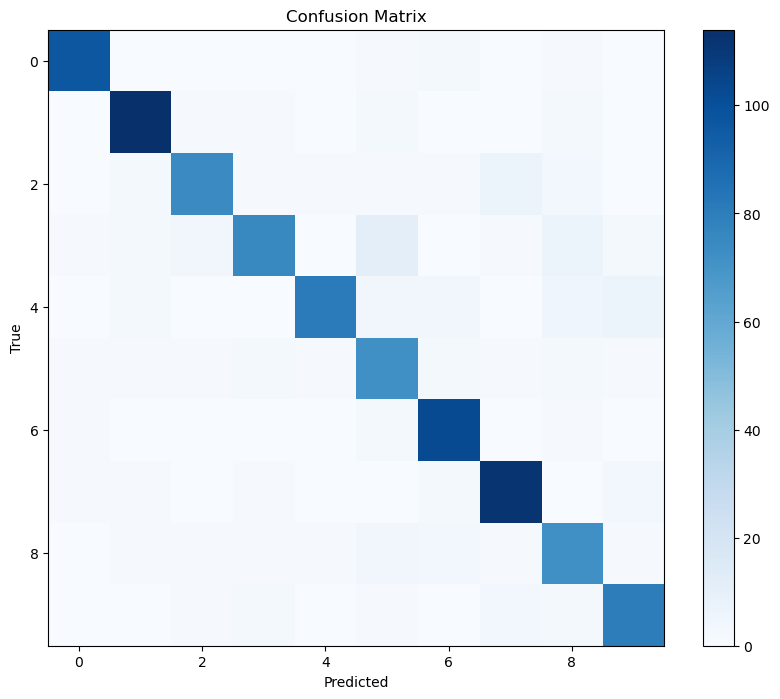

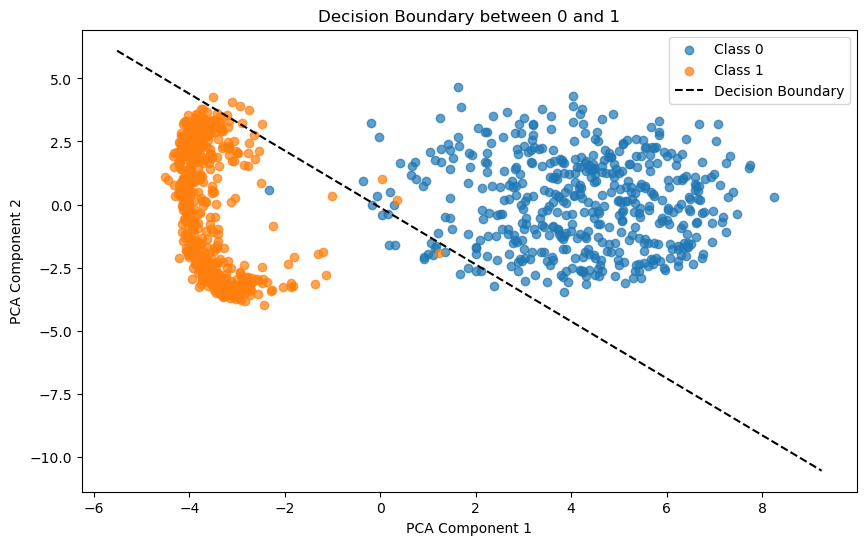

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

# 感知机
class Perceptron:
    def __init__(self, lr=0.01, n_iters=50): # 初始化感知机参数
        self.lr = lr          # 学习率
        self.n_iters = n_iters # 迭代次数
        self.weights = None   # 权重向量
        self.bias = 0.0       # 偏置项

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        # 转换为+1/-1标签
        y_ = np.where(y <= 0, -1, 1)

        # 随机梯度下降SGD 用于更新权重和偏置
        for _ in range(self.n_iters):
            indices = np.random.permutation(n_samples)
            for idx in indices:
                x_i, y_i = X[idx], y_[idx]
                linear_output = np.dot(x_i, self.weights) + self.bias
                if y_i * linear_output <= 0:
                    self.weights += self.lr * y_i * x_i
                    self.bias += self.lr * y_i

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.sign(linear_output)

# 多分类感知机（OvR策略）
class MultiClassPerceptron:
    def __init__(self, n_classes=10, lr=0.01, n_iters=50):
        self.n_classes = n_classes
        self.perceptrons = [Perceptron(lr, n_iters) for _ in range(n_classes)]

    #通过“一对多”策略训练每个感知机。对于每个类别，将当前类别标记为 1，其余类别标记为 0。
    def fit(self, X, y):
        for cls in range(self.n_classes):
            print(f"Training class {cls} vs rest...")
            # 转换为二分类标签
            y_binary = np.where(y == cls, 1, 0)
            self.perceptrons[cls].fit(X, y_binary)

    def predict(self, X):
        scores = np.zeros((X.shape[0], self.n_classes))
        for cls in range(self.n_classes):
            scores[:, cls] = np.dot(X, self.perceptrons[cls].weights) + self.perceptrons[cls].bias
        return np.argmax(scores, axis=1)

# 数据加载与预处理
def load_mnist(sample_size=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data.astype('float32') / 255.0, mnist.target.astype(int)
    # 取前sample_size个样本加速训练（只取了5000个样本）
    return X[:sample_size], y[:sample_size]

X, y = load_mnist(sample_size=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 模型训练
multi_clf = MultiClassPerceptron(n_classes=10, lr=0.1, n_iters=50)
multi_clf.fit(X_train, y_train)

# 3. 模型评估
y_pred = multi_clf.predict(X_test)
print(f"\n测试集准确率: {accuracy_score(y_test, y_pred)*100:.2f}%")

# 打印混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 4. 可视化分析
def visualize_weights(class_idx):
    weights = multi_clf.perceptrons[class_idx].weights.reshape(28,28)
    plt.figure(figsize=(6,6))
    plt.imshow(weights, cmap='coolwarm')
    plt.colorbar()
    plt.title(f"Class {class_idx} vs Rest - Weight Visualization")
    plt.show()

def visualize_decision_boundary(class1=0, class2=1):
    # 只选择两类样本
    mask = (y == class1) | (y == class2)
    X_cls = X[mask]
    y_cls = y[mask]
    
    # 训练二分类模型
    clf = Perceptron(lr=0.1, n_iters=100)
    clf.fit(X_cls, (y_cls == class1).astype(int))
    
    # PCA降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cls)
    
    # 绘图
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[y_cls == class1, 0], X_pca[y_cls == class1, 1], alpha=0.7, label=f'Class {class1}')
    plt.scatter(X_pca[y_cls == class2, 0], X_pca[y_cls == class2, 1], alpha=0.7, label=f'Class {class2}')
    
    # 绘制决策边界
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    
    # 将权重投影到PCA的2维空间
    weights_pca = pca.transform(clf.weights.reshape(1, -1)).flatten()
    intercept = clf.bias
    
    # 计算决策边界
    y_boundary = (-(weights_pca[0] * x_min + intercept) / weights_pca[1],
                  -(weights_pca[0] * x_max + intercept) / weights_pca[1])
    
    plt.plot([x_min, x_max], y_boundary, 'k--', label='Decision Boundary')
    plt.legend()
    plt.title(f"Decision Boundary between {class1} and {class2}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# 可视化类0与类1的决策边界
visualize_decision_boundary(class1=0, class2=1)

对比感知机和SVM

In [24]:
import numpy as np
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron

# 加载 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data.astype('float32') / 255.0, mnist.target.astype(int)

# 使用部分数据加速实验
X, y = X[:5000], y[:5000]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 感知机模型
perceptron = Perceptron(max_iter=50, random_state=42)
start_time = time.time()
perceptron.fit(X_train, y_train)
perceptron_time = time.time() - start_time
perceptron_acc = accuracy_score(y_test, perceptron.predict(X_test))

# SVM 模型
svm = SVC(kernel='linear', C=1.0, random_state=42)
start_time = time.time()
svm.fit(X_train, y_train)
svm_time = time.time() - start_time
svm_acc = accuracy_score(y_test, svm.predict(X_test))

# 输出结果
print(f"感知机准确率: {perceptron_acc * 100:.2f}%，训练时间: {perceptron_time:.2f}s")
print(f"SVM 准确率: {svm_acc * 100:.2f}%，训练时间: {svm_time:.2f}s")

感知机准确率: 88.10%，训练时间: 1.46s
SVM 准确率: 91.60%，训练时间: 1.55s
